# `00` Loading Required Libraries:

In [11]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle
import glob
import scipy.io

# `01` Model Loading:

In [12]:
model = pickle.load(open('./model.pkl', 'rb'))
model

MultiOutputRegressor(estimator=SVR(C=0.7500000000000001,
                                   epsilon=0.07900000000000001, gamma=0.1))

In [13]:
cols = []
for pos in ['nose_', 'forehead_', 'left_eye_', 'mouth_left_', 'chin_', 'right_eye_', 'mouth_right_']:
    for dim in ('x', 'y'):
        cols.append(pos+dim)

In [14]:
def extract_features(img, face_mesh):
    NOSE = 1
    FOREHEAD = 10
    LEFT_EYE = 33
    MOUTH_LEFT = 61
    CHIN = 199
    RIGHT_EYE = 263
    MOUTH_RIGHT = 291

    result = face_mesh.process(img)
    face_features = []
    
    if result.multi_face_landmarks != None:
        for face_landmarks in result.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in [FOREHEAD, NOSE, MOUTH_LEFT, MOUTH_RIGHT, CHIN, LEFT_EYE, RIGHT_EYE]:
                    face_features.append(lm.x)
                    face_features.append(lm.y)

    return face_features

In [15]:
def normalize(poses_df):
    normalized_df = poses_df.copy()
    
    for dim in ['x', 'y']:
        # Centerning around the nose 
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = poses_df[feature] - poses_df['nose_'+dim]
        
        
        # Scaling
        diff = normalized_df['mouth_right_'+dim] - normalized_df['left_eye_'+dim]
        for feature in ['forehead_'+dim, 'nose_'+dim, 'mouth_left_'+dim, 'mouth_right_'+dim, 'left_eye_'+dim, 'chin_'+dim, 'right_eye_'+dim]:
            normalized_df[feature] = normalized_df[feature] / diff
    
    return normalized_df

In [16]:
def draw_axes(img, pitch, yaw, roll, tx, ty, size=50):
    yaw = -yaw
    rotation_matrix = cv2.Rodrigues(np.array([pitch, yaw, roll]))[0].astype(np.float64)
    axes_points = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float64)
    axes_points = rotation_matrix @ axes_points
    axes_points = (axes_points[:2, :] * size).astype(int)
    axes_points[0, :] = axes_points[0, :] + tx
    axes_points[1, :] = axes_points[1, :] + ty
    
    new_img = img.copy()
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 0].ravel()), (255, 0, 0), 3)    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 1].ravel()), (0, 255, 0), 3)    
    cv2.line(new_img, tuple(axes_points[:, 3].ravel()), tuple(axes_points[:, 2].ravel()), (0, 0, 255), 3)
    return new_img

# `02` Testing the Model on Training Images:

Image shape:  (450, 450, 3)
targets:  [-0.15810244  0.34346703 -0.3815295 ]


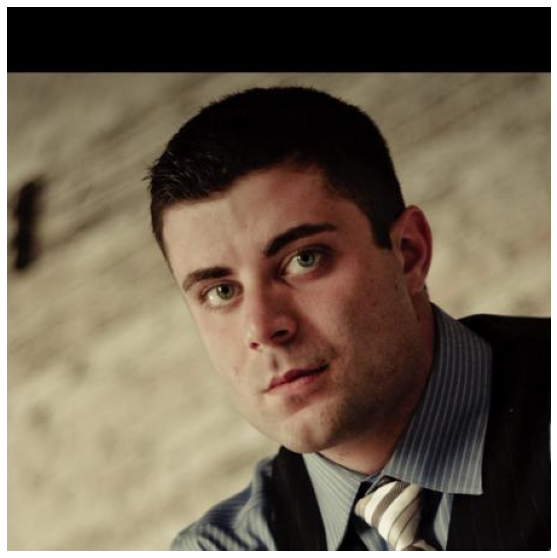

In [17]:
DEMO_IMG_NUMBER = 11
images_paths = glob.glob('./AFLW2000/*.jpg')
img = cv2.imread(images_paths[DEMO_IMG_NUMBER])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: ', img.shape)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img);

img_info_paths = glob.glob('./AFLW2000/*.mat')
mat = scipy.io.loadmat(img_info_paths[DEMO_IMG_NUMBER])
print('targets: ', mat['Pose_Para'][0][:3].ravel())                 #Extracting Pitch, Yaw, and Roll

In [18]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_features = extract_features(img, face_mesh)
face_features_df = pd.DataFrame([face_features], columns=cols)
face_features_normalized = normalize(face_features_df)
pitch_pred, yaw_pred, roll_pred = model.predict(face_features_normalized).ravel()
print('predictions: ', pitch_pred, yaw_pred, roll_pred)

predictions:  -0.102243356637072 0.3247649202648226 -0.3963076864256852


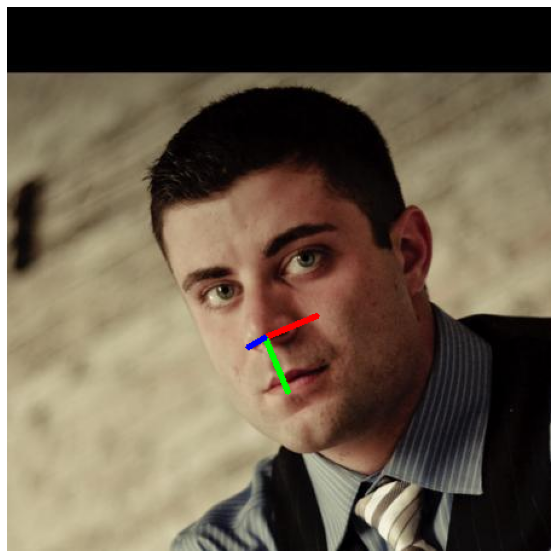

In [19]:
img_h, img_w, img_c = img.shape
nose_x = face_features_df['nose_x'].values * img_w
nose_y = face_features_df['nose_y'].values * img_h

new_img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(new_img);

# `05` Testing on Camera:

In [20]:
face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)

cap = cv2.VideoCapture(0)  # From Camera

while(cap.isOpened()):

    # Take each frame
    ret, img = cap.read()
    if ret:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.flip(img, 1)
        img_h, img_w, img_c = img.shape
        text = ''
        
        
        face_features = extract_features(img, face_mesh)
        if len(face_features):
            face_features_df = pd.DataFrame([face_features], columns=cols)
            face_features_normalized = normalize(face_features_df)
            pitch_pred, yaw_pred, roll_pred = model.predict(face_features_normalized).ravel()
            nose_x = face_features_df['nose_x'].values * img_w
            nose_y = face_features_df['nose_y'].values * img_h
            img = draw_axes(img, pitch_pred, yaw_pred, roll_pred, nose_x, nose_y)
                        
            if pitch_pred > 0.3:
                text = 'Top'
                if yaw_pred > 0.3:
                    text = 'Top Left'
                elif yaw_pred < -0.3:
                    text = 'Top Right'
            elif pitch_pred < -0.3:
                text = 'Bottom'
                if yaw_pred > 0.3:
                    text = 'Bottom Left'
                elif yaw_pred < -0.3:
                    text = 'Bottom Right'
            elif yaw_pred > 0.3:
                text = 'Left'
            elif yaw_pred < -0.3:
                text = 'Right'
            else:
                text = 'Forward'
                
        cv2.putText(img, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imshow('img', img)
        k = cv2.waitKey(1) & 0xFF
        if k == ord("q"):
            break
    else:
        break

cv2.destroyAllWindows()
cap.release()